# **Predicting Fraud in auto insurance claims**

In [1]:
#Importing required libraries and modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Business Problem**:
    Frauds are unethical and are losses to the company. It takes lot of time to investigate into each claim. By building a model that can classify auto insurance fraud, I am able to cut losses for the insurance company. Less losses equates to more earning. The goal of this project is to build a model that can detect auto insurance fraud. The model should be able to classify if a claim is fraud or not on a dataset that it has not seen. This measured by the F1score in this project.

In [3]:
# Read the files
Train_Claim = pd.read_csv("/content/gdrive/MyDrive/TrainData/Train_Claim.csv",na_values =["-5","MISSINGVALUE","MISSEDDATA"])
Train_Demo = pd.read_csv("/content/gdrive/MyDrive/TrainData/Train_Demographics.csv")
Train_Policy = pd.read_csv("/content/gdrive/MyDrive/TrainData/Train_Policy.csv", na_values=["-1", "MISSINGVAL"])
Train_Vehicle = pd.read_csv("/content/gdrive/MyDrive/TrainData/Train_Vehicle.csv", na_values="???")
Train= pd.read_csv("/content/gdrive/MyDrive/TrainData/Traindata_with_Target-1621048083876.csv")

In [4]:
# Checking number of Records and Attributes for each file
print(Train_Claim.shape)
print(Train_Demo.shape)
print(Train_Policy.shape)
print(Train_Vehicle.shape)
print(Train.shape)

(28836, 19)
(28836, 10)
(28836, 10)
(115344, 3)
(28836, 2)


In [5]:
# Checking unique ID's in each file
print(Train_Claim.CustomerID.nunique())
print(Train_Demo.CustomerID.nunique())
print(Train_Policy.CustomerID.nunique())
print(Train_Vehicle.CustomerID.nunique())
print(Train.CustomerID.nunique())

28836
28836
28836
28836
28836


In [6]:
#Checking whether same Ids are present in each file or not
i1=list(set(Train.CustomerID)-set(Train_Claim.CustomerID))
print(len(i1))
i2=list(set(Train_Claim.CustomerID)-set(Train.CustomerID))
print(len(i2))
i3 = list(set(Train.CustomerID)-set(Train_Policy.CustomerID))
print(len(i3))
i4 = list(set(Train.CustomerID)-set(Train_Demo.CustomerID))
print(len(i4))
i5= list(set(Train.CustomerID)-set(Train_Vehicle.CustomerID))
print(len(i5))

0
0
0
0
0


In [7]:
#Creating seperate columns for VehicleMake, model and mafacturing since everything is incluced in the same column
df= pd.crosstab(Train_Vehicle['CustomerID'], Train_Vehicle['VehicleAttribute'],Train_Vehicle['VehicleAttributeDetails'],aggfunc='first',rownames=['CustomerID'],colnames=['VehicleAttribute'])

In [8]:


df.head()

VehicleAttribute,VehicleID,VehicleMake,VehicleModel,VehicleYOM
CustomerID,,,,
Cust10000,Vehicle26917,Audi,A5,2008
Cust10001,Vehicle15893,Audi,A5,2006
Cust10002,Vehicle5152,Volkswagen,Jetta,1999
Cust10003,Vehicle37363,Volkswagen,Jetta,2003
Cust10004,Vehicle28633,Toyota,CRV,2010


In [9]:
# Merging files into Consolidated one
df1 = pd.merge(Train, Train_Claim, on='CustomerID', how='left')
df2 = pd.merge(df1, Train_Demo, on='CustomerID', how='left')
df3 = pd.merge(df2, Train_Policy, on='CustomerID', how='left')
merged_data = pd.merge(df3, df,on='CustomerID', how='left' )

In [10]:
merged_data.ReportedFraud.value_counts(normalize=True)*100

N    73.002497
Y    26.997503
Name: ReportedFraud, dtype: float64

In [11]:
merged_data.shape

(28836, 42)

In [12]:
merged_data.dtypes

CustomerID                     object
ReportedFraud                  object
DateOfIncident                 object
TypeOfIncident                 object
TypeOfCollission               object
SeverityOfIncident             object
AuthoritiesContacted           object
IncidentState                  object
IncidentCity                   object
IncidentAddress                object
IncidentTime                  float64
NumberOfVehicles                int64
PropertyDamage                 object
BodilyInjuries                  int64
Witnesses                     float64
PoliceReport                   object
AmountOfTotalClaim            float64
AmountOfInjuryClaim             int64
AmountOfPropertyClaim           int64
AmountOfVehicleDamage           int64
InsuredAge                      int64
InsuredZipCode                  int64
InsuredGender                  object
InsuredEducationLevel          object
InsuredOccupation              object
InsuredHobbies                 object
CapitalGains

**Observation**:
  DateOfIncident need to be converted into date format.
  Attributes like IncidentTime, NumberOfVehicles, BodilyInjuries, Witnesses, InsuredZipCode, InsurancePolicyNumber are intrepreted incorrectly. These attributes need to be converted into category.

In [13]:
unknowns = {}
for i in list(merged_data.columns):
    if (merged_data[i]).dtype == object:
        j = np.sum(merged_data[i] == "?")
        unknowns[i] = j
unknowns = pd.DataFrame.from_dict(unknowns, orient = 'index')
print(unknowns)

                                0
CustomerID                      0
ReportedFraud                   0
DateOfIncident                  0
TypeOfIncident                  0
TypeOfCollission             5162
SeverityOfIncident              0
AuthoritiesContacted            0
IncidentState                   0
IncidentCity                    0
IncidentAddress                 0
PropertyDamage              10459
PoliceReport                 9805
InsuredGender                   0
InsuredEducationLevel           0
InsuredOccupation               0
InsuredHobbies                  0
Country                         0
DateOfPolicyCoverage            0
InsurancePolicyState            0
Policy_CombinedSingleLimit      0
InsuredRelationship             0
VehicleID                       0
VehicleMake                     0
VehicleModel                    0
VehicleYOM                      0


**Observation**: There are huge misssing values for the attributes such as Type of collision, Property damage and Police report. These attributes need to be investigated first.

In [14]:
x = merged_data.TypeOfCollission.value_counts()
x = x.sort_values()
x

?                  5162
Front Collision    7246
Side Collision     7867
Rear Collision     8561
Name: TypeOfCollission, dtype: int64

# **EDA**

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


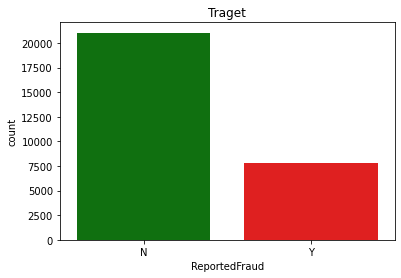

In [16]:
plt.title('Traget')
sns.countplot('ReportedFraud',data=merged_data,palette=['green','red'])

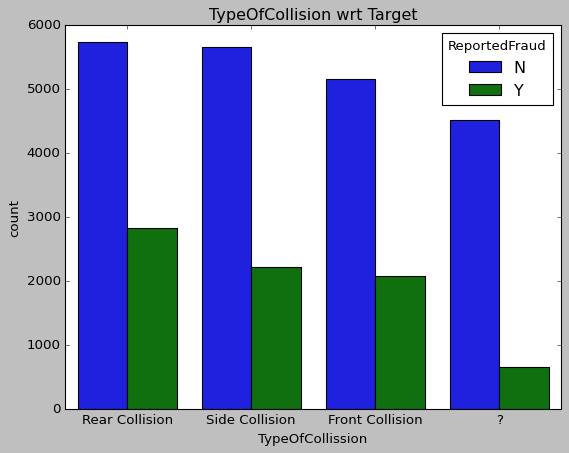

In [17]:
plt.style.use('classic')
plt.title("TypeOfCollision wrt Target")
plt.xlabel("Type of collision")
sns.countplot(x="TypeOfCollission", hue="ReportedFraud", data=merged_data)

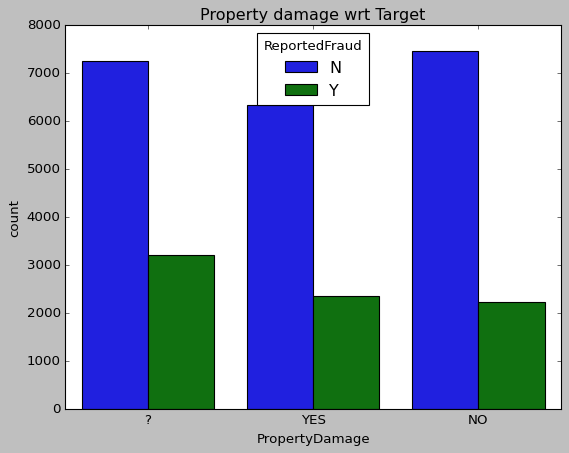

In [18]:
plt.title("Property damage wrt Target")
plt.xlabel("PropertyDamage")
sns.countplot(x="PropertyDamage", hue="ReportedFraud", data=merged_data)

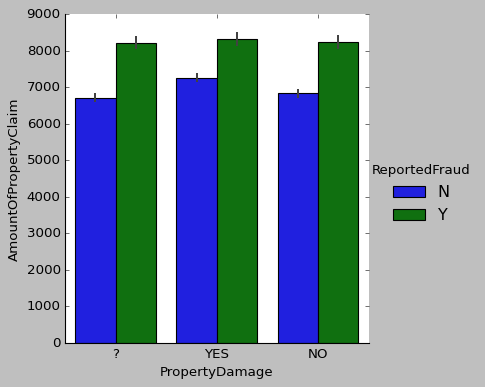

In [19]:
sns.catplot( x="PropertyDamage", y="AmountOfPropertyClaim", kind="bar", hue='ReportedFraud', data=merged_data)

**Observation:**
   There are more records where information about property damage is not mentioned in case of fraud. 

Text(0.5, 1.0, 'PropertyDamage VS Amount of Property Claim')

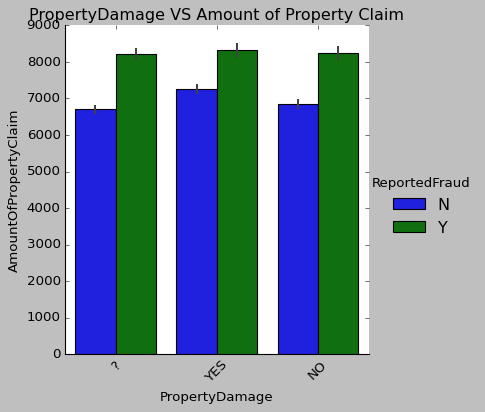

In [20]:
ax = sns.catplot(x="PropertyDamage", y="AmountOfPropertyClaim", hue="ReportedFraud", kind="bar", orient="v", data=merged_data)
ax.set_xticklabels(rotation=45)
plt.title('PropertyDamage VS Amount of Property Claim')

**Observation**:
  In all the cases whether property had been damaged or not, huge amount had been claimed for fraud records
  

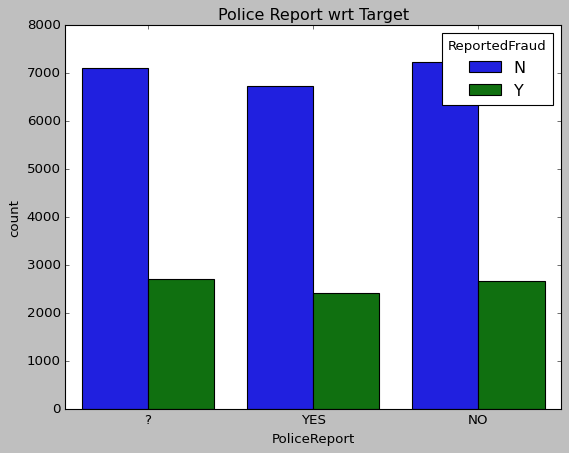

In [21]:
plt.title("Police Report wrt Target")
plt.xlabel("Police Report")
sns.countplot(x="PoliceReport", hue="ReportedFraud", data=merged_data)

Text(0.5, 1.0, 'PoliceReport VS Amount of Total Claim')

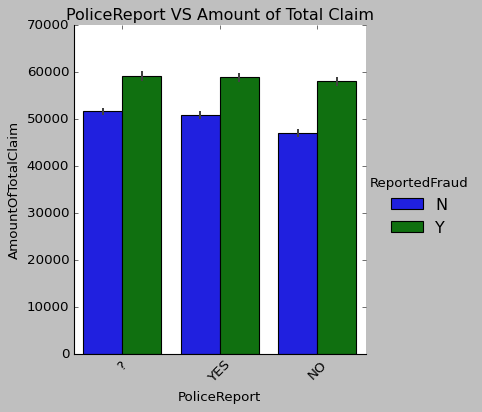

In [22]:
ax = sns.catplot(x="PoliceReport", y="AmountOfTotalClaim", hue="ReportedFraud", kind="bar", orient="v", data=merged_data)
ax.set_xticklabels(rotation=45)
plt.title('PoliceReport VS Amount of Total Claim')

**Observation**:
  More amount had been claimed in case of fraud records compared to non-fraud ones
  

Text(0.5, 1.0, 'Severity of Incident VS Amount of Total Claim')

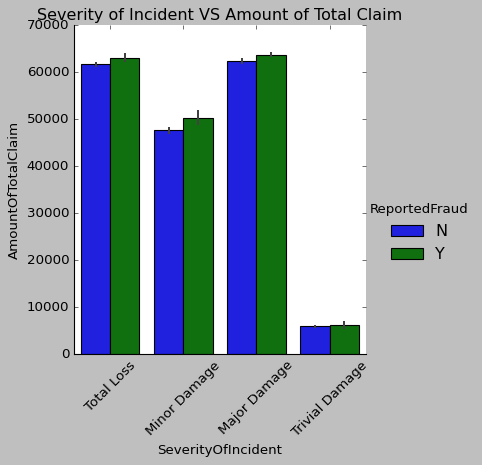

In [23]:
ax = sns.catplot(x="SeverityOfIncident", y="AmountOfTotalClaim", hue="ReportedFraud", kind="bar", orient="v", data=merged_data)
ax.set_xticklabels(rotation=45)
plt.title('Severity of Incident VS Amount of Total Claim')

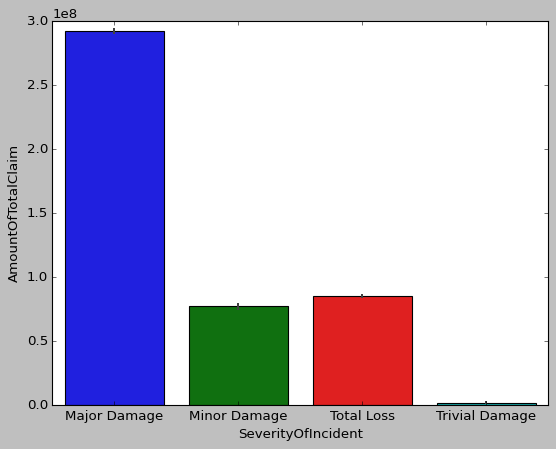

In [24]:
from numpy import sum
fraud = merged_data[merged_data.ReportedFraud=='Y']
sns.barplot(x='SeverityOfIncident', y='AmountOfTotalClaim', data=fraud, estimator=sum)


In [25]:
%who DataFrame

Train	 Train_Claim	 Train_Demo	 Train_Policy	 Train_Vehicle	 df	 df1	 df2	 df3	 
fraud	 merged_data	 unknowns	 


In [26]:
type(fraud)

pandas.core.frame.DataFrame

**Observation**:
  Huge sum of amount had been claimed for major damage incase of fraud records.

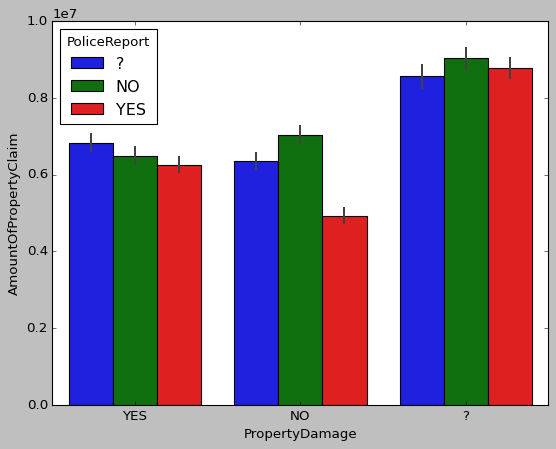

In [27]:
fraud_prop = merged_data[merged_data.ReportedFraud=='Y']
ax = sns.barplot(x='PropertyDamage', y='AmountOfPropertyClaim', hue='PoliceReport', data=fraud_prop, estimator=sum)


**Observation:**
  Huge sum of amount had been claimed for the records where property damage information had been not mentioned
  

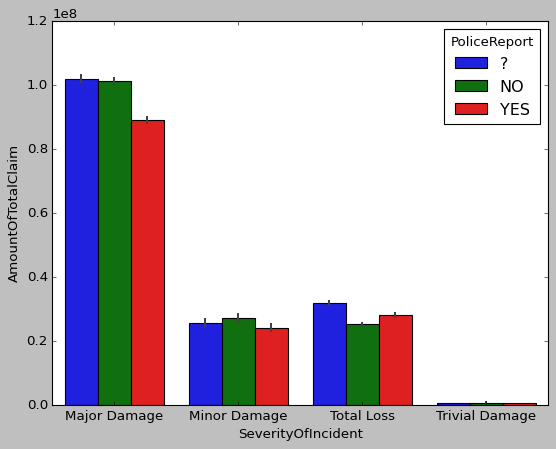

In [28]:
fraud_incident = merged_data[merged_data.ReportedFraud=='Y']
sns.barplot(x='SeverityOfIncident', y='AmountOfTotalClaim', hue='PoliceReport', data=fraud_prop, estimator=sum)

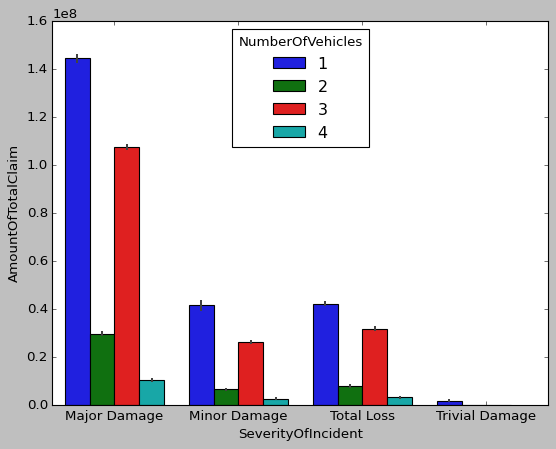

In [29]:
fraud_vehicles = merged_data[merged_data.ReportedFraud=='Y']
sns.barplot(x='SeverityOfIncident', y='AmountOfTotalClaim', hue='NumberOfVehicles', data=fraud_vehicles, estimator=sum)

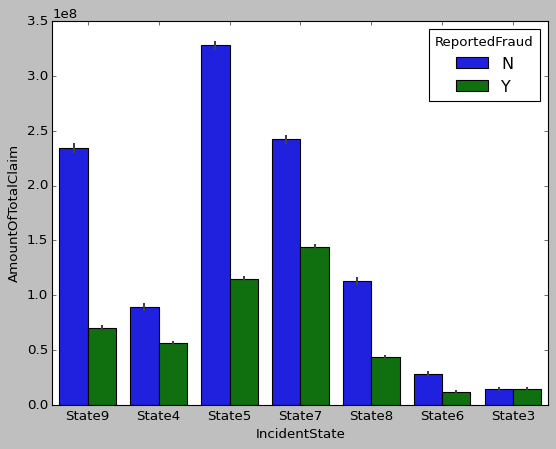

In [30]:
sns.barplot(x='IncidentState', y='AmountOfTotalClaim', hue='ReportedFraud', data=merged_data, estimator=sum)

**Observation:**
  State7 and State5 are top two states where fraud claims are more in number compared to other states.

In [31]:
# Converting Hour of the day to Period of the day
bins = [ -5, 0, 3, 6, 9, 12, 17, 20, 24]
names = ["Not_known", "past_midnight", "early_morning", "morning", "fore-noon", "afternoon", "evening", "night"]
merged_data['IncidentPeriod']= pd.cut(merged_data['IncidentTime'], bins=bins, labels=names)

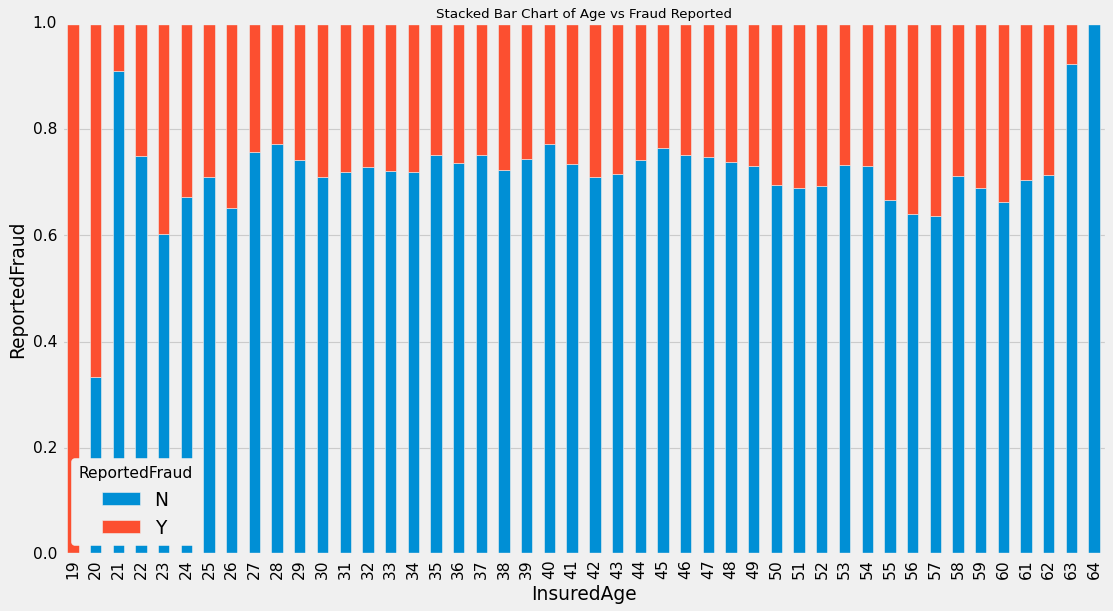

In [32]:
plt.rcParams['figure.figsize'] = [15, 8]
ax= plt.style.use('fivethirtyeight')
table=pd.crosstab(merged_data.InsuredAge, merged_data.ReportedFraud)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Age vs Fraud Reported', fontsize=12)
plt.xlabel('InsuredAge')
plt.ylabel('ReportedFraud')
plt.show()

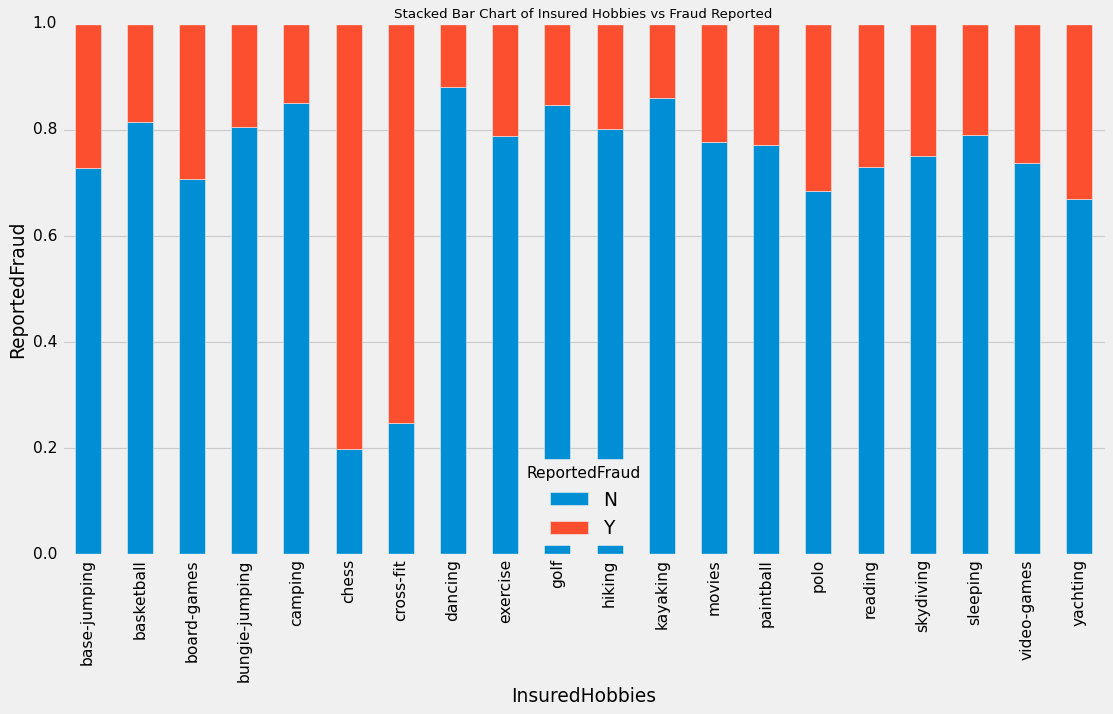

In [33]:





plt.rcParams['figure.figsize'] = [15, 8]
ax= plt.style.use('fivethirtyeight')
table=pd.crosstab(merged_data.InsuredHobbies, merged_data.ReportedFraud)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Insured Hobbies vs Fraud Reported', fontsize=12)
plt.xlabel('InsuredHobbies')
plt.ylabel('ReportedFraud')
plt.show()

**Observation**:
    

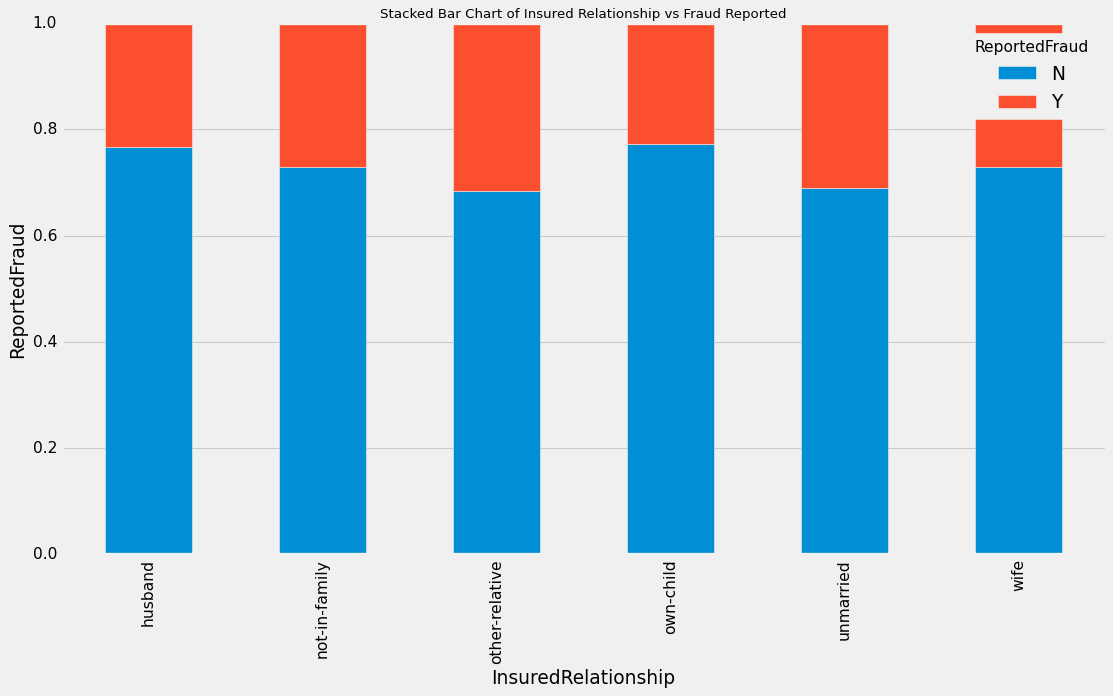

In [34]:
plt.rcParams['figure.figsize'] = [15, 8]
ax= plt.style.use('fivethirtyeight')
table=pd.crosstab(merged_data.InsuredRelationship, merged_data.ReportedFraud)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Insured Relationship vs Fraud Reported', fontsize=12)
plt.xlabel('InsuredRelationship')
plt.ylabel('ReportedFraud')
plt.show()

Text(0.5, 1.0, 'Severity of Incident VS Amount of Injury Claim')

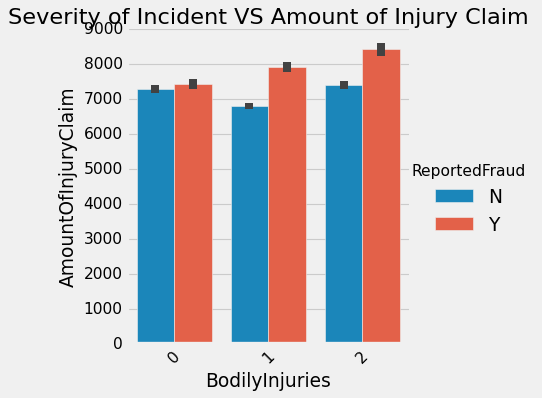

In [35]:
ax = sns.catplot(x="BodilyInjuries", y="AmountOfInjuryClaim", hue="ReportedFraud", kind="bar", orient="v", data=merged_data)
ax.set_xticklabels(rotation=45)
plt.title('Severity of Incident VS Amount of Injury Claim')

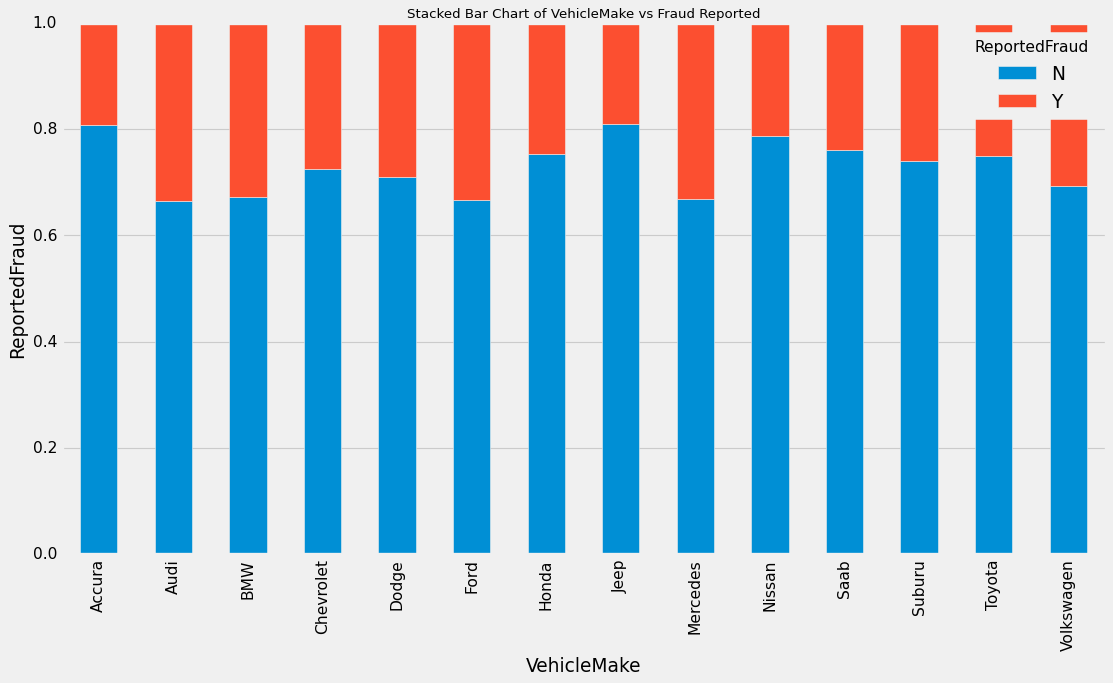

In [36]:
plt.rcParams['figure.figsize'] = [15, 8]
ax= plt.style.use('fivethirtyeight')
table=pd.crosstab(merged_data.VehicleMake, merged_data.ReportedFraud)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of VehicleMake vs Fraud Reported', fontsize=12)
plt.xlabel('VehicleMake')
plt.ylabel('ReportedFraud')
plt.show()

Text(0.5, 1.0, 'Bodily Injuries VS Amount of Vehicle Damage')

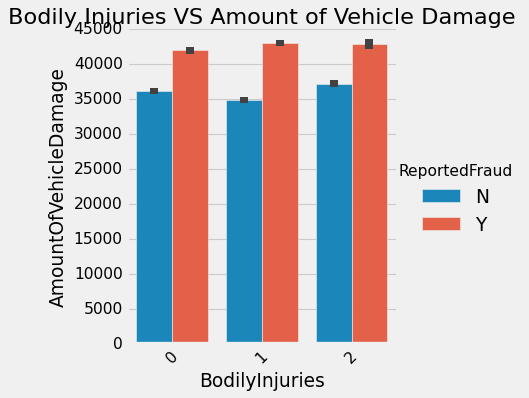

In [37]:
ax = sns.catplot(x="BodilyInjuries", y="AmountOfVehicleDamage", hue="ReportedFraud", kind="bar", orient="v", data=merged_data)
ax.set_xticklabels(rotation=45)
plt.title('Bodily Injuries VS Amount of Vehicle Damage')

In [38]:
merged_data['Status'] = merged_data['CapitalGains'] + merged_data['CapitalLoss']

Text(0.5, 1.0, 'Financial Status Vs Reported Fraud')

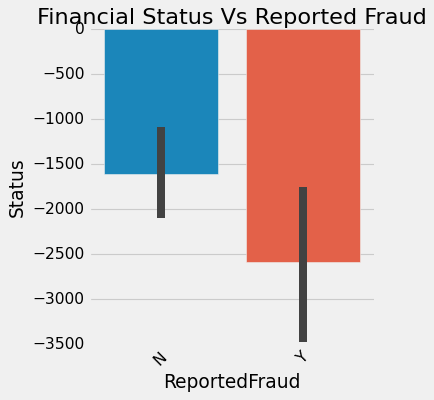

In [39]:
ax = sns.catplot(x="ReportedFraud", y="Status", kind="bar", orient="v", data=merged_data)
ax.set_xticklabels(rotation=45)
plt.title('Financial Status Vs Reported Fraud')

In [40]:
col = ['NumberOfVehicles', 'BodilyInjuries', 'Witnesses', 'InsuredZipCode', 'InsurancePolicyNumber', 'IncidentTime']
for i in col:
  merged_data[col] = merged_data[col].astype('object')

In [41]:
# Converting into date format
merged_data["DateOfIncident"] = pd.to_datetime(merged_data["DateOfIncident"])
merged_data["DateOfPolicyCoverage"] = pd.to_datetime(merged_data["DateOfPolicyCoverage"])

In [42]:
#Converting into apropriate data types
cat_cols = merged_data.select_dtypes(include=['object']).columns
print(len(cat_cols))
merged_data[cat_cols] = merged_data[cat_cols].astype('category')

29


In [43]:
num_cols = merged_data.select_dtypes(include=['int64', 'float64']).columns
print(len(num_cols))

12


In [44]:
#Checking summary statistics for Numerical attributes
merged_data.describe()

,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsuredAge,CapitalGains,CapitalLoss,CustomerLoyaltyPeriod,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,Status
count,28786.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28836.000000,28695.000000,2.883600e+04,28836.000000
mean,52308.545473,7337.118428,7283.870197,37687.129387,38.815370,23066.569566,-24940.612429,203.067867,1114.282529,1261.702646,9.836680e+05,-1874.042863
std,25101.172550,4427.638593,4375.842738,17977.048232,7.996377,27637.813724,27913.209608,99.932951,546.632816,205.385158,1.969282e+06,38285.827348
min,150.000000,0.000000,0.000000,109.000000,19.000000,0.000000,-111100.000000,1.000000,500.000000,436.280000,-1.000000e+06,-111100.000000
25%,44643.750000,4743.750000,4862.000000,32193.250000,33.000000,0.000000,-50000.000000,126.000000,622.000000,1124.425000,0.000000e+00,-31600.000000
50%,58360.000000,7147.000000,7051.000000,42457.500000,38.000000,0.000000,0.000000,199.000000,1000.000000,1266.440000,0.000000e+00,0.000000
75%,68982.750000,10571.250000,10327.000000,49535.750000,44.000000,49000.000000,0.000000,267.000000,1627.000000,1397.200000,4.859610e+05,21500.000000
max,114920.000000,21450.000000,23670.000000,79560.000000,64.000000,100500.000000,0.000000,479.000000,2000.000000,2047.590000,1.000000e+07,100500.000000


In [45]:
#Checking summary statistics for categorical attributes
merged_data.describe(include='category')

,CustomerID,ReportedFraud,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,Country,InsurancePolicyNumber,InsurancePolicyState,Policy_CombinedSingleLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,IncidentPeriod
count,28836,28836,28836,28836,28836,28836,28836,28836,28836,28805.0,...,28834,28836,28836,28836,28836,28836,28786,28836,28836,28805
unique,28836,2,4,4,4,5,7,7,1000,24.0,...,1,28836,3,9,6,28836,14,39,21,8
top,Cust10000,N,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,State5,City2,Location 1341,16.0,...,India,110122,State3,250/500,own-child,Vehicle10000,Saab,RAM,2007,afternoon
freq,1,21051,11966,8561,10400,8324,7886,4486,73,1616.0,...,28834,1,10146,8260,5242,1,2415,1344,1730,7653


In [46]:
#Displaying first few records
merged_data.head()

,CustomerID,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,...,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,IncidentPeriod,Status
0,Cust20065,N,2015-01-09,Multi-vehicle Collision,Rear Collision,Total Loss,Other,State9,City4,Location 1404,...,2000,1142.87,0,own-child,Vehicle30662,Mercedes,E400,2005,evening,-42700
1,Cust37589,N,2015-02-20,Single Vehicle Collision,Side Collision,Minor Damage,Ambulance,State4,City3,Location 1675,...,1000,1274.38,2857344,own-child,Vehicle17183,Toyota,Highlander,2010,afternoon,51300
2,Cust24312,N,2015-01-14,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State5,City2,Location 1546,...,745,1269.93,0,other-relative,Vehicle33982,Volkswagen,Passat,2002,night,0
3,Cust5493,Y,2015-01-07,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State7,City4,Location 1413,...,986,1218.60,0,other-relative,Vehicle12299,Toyota,Highlander,2011,fore-noon,-8700
4,Cust7704,Y,2015-02-26,Multi-vehicle Collision,Side Collision,Major Damage,Other,State4,City6,Location 1367,...,576,1431.02,4235779,unmarried,Vehicle30447,Ford,Wrangler,2010,past_midnight,0


In [47]:
#Printing column names
merged_data.columns

Index(['CustomerID', 'ReportedFraud', 'DateOfIncident', 'TypeOfIncident',
       'TypeOfCollission', 'SeverityOfIncident', 'AuthoritiesContacted',
       'IncidentState', 'IncidentCity', 'IncidentAddress', 'IncidentTime',
       'NumberOfVehicles', 'PropertyDamage', 'BodilyInjuries', 'Witnesses',
       'PoliceReport', 'AmountOfTotalClaim', 'AmountOfInjuryClaim',
       'AmountOfPropertyClaim', 'AmountOfVehicleDamage', 'InsuredAge',
       'InsuredZipCode', 'InsuredGender', 'InsuredEducationLevel',
       'InsuredOccupation', 'InsuredHobbies', 'CapitalGains', 'CapitalLoss',
       'Country', 'InsurancePolicyNumber', 'CustomerLoyaltyPeriod',
       'DateOfPolicyCoverage', 'InsurancePolicyState',
       'Policy_CombinedSingleLimit', 'Policy_Deductible',
       'PolicyAnnualPremium', 'UmbrellaLimit', 'InsuredRelationship',
       'VehicleID', 'VehicleMake', 'VehicleModel', 'VehicleYOM',
       'IncidentPeriod', 'Status'],
      dtype='object')

In [48]:
#Checking for missing values
merged_data.isnull().sum()

CustomerID                      0
ReportedFraud                   0
DateOfIncident                  0
TypeOfIncident                  0
TypeOfCollission                0
SeverityOfIncident              0
AuthoritiesContacted            0
IncidentState                   0
IncidentCity                    0
IncidentAddress                 0
IncidentTime                   31
NumberOfVehicles                0
PropertyDamage                  0
BodilyInjuries                  0
Witnesses                      46
PoliceReport                    0
AmountOfTotalClaim             50
AmountOfInjuryClaim             0
AmountOfPropertyClaim           0
AmountOfVehicleDamage           0
InsuredAge                      0
InsuredZipCode                  0
InsuredGender                  30
InsuredEducationLevel           0
InsuredOccupation               0
InsuredHobbies                  0
CapitalGains                    0
CapitalLoss                     0
Country                         2
InsurancePolic

In [49]:
Time_attr = ['DateOfIncident', 'DateOfPolicyCoverage']

In [50]:
#Labelling Target Attribute
merged_data['ReportedFraud'].replace(to_replace='Y', value=1, inplace=True)
merged_data['ReportedFraud'].replace(to_replace='N', value=0, inplace=True)

In [51]:
#Base MOdel
data = merged_data.copy()

In [52]:
#columns to drop for the first model
cols_to_drop = ['CustomerID', 'IncidentState', 'IncidentCity','IncidentAddress', 'IncidentTime', 
                 'InsuredZipCode', 'InsuredEducationLevel', 'InsuredOccupation', 'InsuredHobbies',
                'Country', 'InsurancePolicyNumber', 'DateOfPolicyCoverage','InsurancePolicyState', 
               'InsuredRelationship', 'VehicleID', 'VehicleModel'] 

In [53]:
#Dropping those columns
data.drop(columns=cols_to_drop, axis=1, inplace=True)

In [54]:
len(data.columns)

28

In [55]:
data.shape

(28836, 28)

# **Feautre Engineering**

In [56]:
#Extracting year from Date of Incident
data['Year'] = data['DateOfIncident'].dt.year

In [57]:
data['VehicleYOM'] = data['VehicleYOM'].astype(int)

In [58]:
#Creating new column Ageofvehicle 
data['AgeOfVehicle'] = data['Year'] - data['VehicleYOM']

In [59]:
data.drop(['DateOfIncident', 'Year', 'VehicleYOM'], axis=1, inplace=True)

In [60]:
data.shape

(28836, 27)

In [61]:
#data.dropna(axis=0, inplace=True)

In [62]:
 #Imputing missing values in Amountoftotalclaim by summing up the amounts of injury, property and vehicledamage
 data['AmountOfTotalClaim']= data['AmountOfInjuryClaim'] + data['AmountOfPropertyClaim'] + data['AmountOfVehicleDamage']

In [63]:
lst1 = ['TypeOfCollission', 'PropertyDamage', 'PoliceReport']
data[lst1] = data[lst1].astype('category')

In [64]:
cat_col= data.select_dtypes(include=['category']).columns
cat_attr = cat_col.drop('ReportedFraud')
print(cat_attr)
print(len(cat_attr))

Index(['TypeOfIncident', 'TypeOfCollission', 'SeverityOfIncident',
       'AuthoritiesContacted', 'NumberOfVehicles', 'PropertyDamage',
       'BodilyInjuries', 'Witnesses', 'PoliceReport', 'InsuredGender',
       'Policy_CombinedSingleLimit', 'VehicleMake', 'IncidentPeriod'],
      dtype='object')
13


In [65]:
num_attr =['AmountOfTotalClaim', 'AmountOfInjuryClaim',	'AmountOfPropertyClaim',
           'InsuredAge', 'CapitalGains', 'CapitalLoss',	
           'Policy_Deductible',	'PolicyAnnualPremium', 'UmbrellaLimit', 'Status',
            'AgeOfVehicle']
print(len(num_attr))

11


In [66]:
data.shape

(28836, 27)

In [67]:
# Label Encoding
le = LabelEncoder()
data['TypeOfCollission']= le.fit_transform(data['TypeOfCollission'])
data['PoliceReport'] = le.fit_transform(data['PoliceReport'])
data['PropertyDamage'] = le.fit_transform(data['PropertyDamage'])


In [68]:
lst1 = ['TypeOfCollission', 'PropertyDamage', 'PoliceReport']
data[lst1] = data[lst1].astype('category')

In [69]:
data.dtypes

ReportedFraud                 category
TypeOfIncident                category
TypeOfCollission              category
SeverityOfIncident            category
AuthoritiesContacted          category
NumberOfVehicles              category
PropertyDamage                category
BodilyInjuries                category
Witnesses                     category
PoliceReport                  category
AmountOfTotalClaim               int64
AmountOfInjuryClaim              int64
AmountOfPropertyClaim            int64
AmountOfVehicleDamage            int64
InsuredAge                       int64
InsuredGender                 category
CapitalGains                     int64
CapitalLoss                      int64
CustomerLoyaltyPeriod            int64
Policy_CombinedSingleLimit    category
Policy_Deductible                int64
PolicyAnnualPremium            float64
UmbrellaLimit                    int64
VehicleMake                   category
IncidentPeriod                category
Status                   

In [70]:
data.head()

,ReportedFraud,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,...,CapitalLoss,CustomerLoyaltyPeriod,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,VehicleMake,IncidentPeriod,Status,AgeOfVehicle
0,0,Multi-vehicle Collision,2,Total Loss,Other,3,0,1,1.0,0,...,-42700,432,250/500,2000,1142.87,0,Mercedes,evening,-42700,10
1,0,Single Vehicle Collision,3,Minor Damage,Ambulance,1,0,1,1.0,2,...,0,128,100/300,1000,1274.38,2857344,Toyota,afternoon,51300,5
2,0,Multi-vehicle Collision,3,Major Damage,Ambulance,3,0,0,0.0,0,...,0,346,500/1000,745,1269.93,0,Volkswagen,night,0,13
3,1,Multi-vehicle Collision,3,Major Damage,Ambulance,3,2,2,0.0,0,...,-56100,42,100/300,986,1218.60,0,Toyota,fore-noon,-8700,4
4,1,Multi-vehicle Collision,3,Major Damage,Other,3,1,1,2.0,1,...,0,109,250/500,576,1431.02,4235779,Ford,past_midnight,0,5


In [71]:
#Splitting the data into train and validation sets
y = data['ReportedFraud']
X = data.drop('ReportedFraud', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

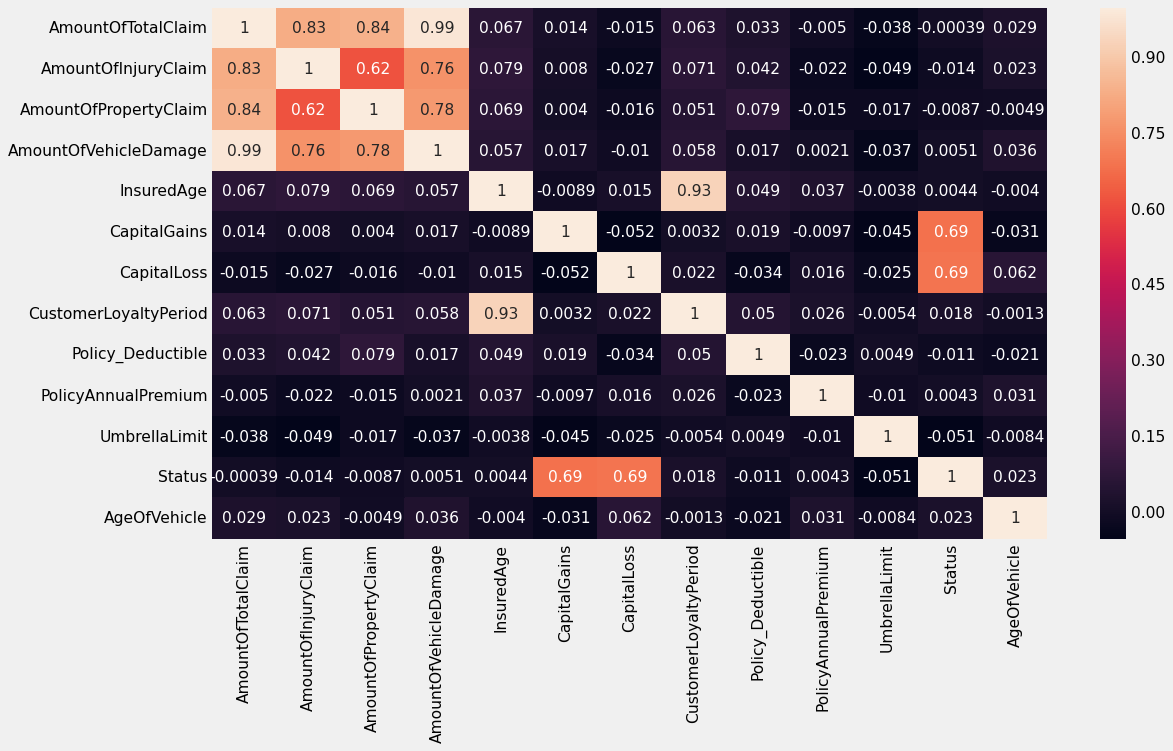

In [72]:
cor = X_train.corr()
ax = sns.heatmap(cor, annot=True)


In [73]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [74]:
corr_features = correlation(X_train, 0.85)
len(set(corr_features))

2

In [75]:
corr_features

{'AmountOfVehicleDamage', 'CustomerLoyaltyPeriod'}

In [76]:
X_train.drop(corr_features,axis=1)
X_test.drop(corr_features,axis=1)

,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,...,CapitalGains,CapitalLoss,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,VehicleMake,IncidentPeriod,Status,AgeOfVehicle
16782,Multi-vehicle Collision,2,Minor Damage,Police,2,0,2,1.0,2,68520,...,0,0,250/500,1400,1037.86,0,Dodge,fore-noon,0,13
12446,Parked Car,0,Minor Damage,Police,1,1,1,0.0,1,5543,...,0,-58100,100/300,567,1417.70,0,Toyota,early_morning,-58100,11
9210,Single Vehicle Collision,2,Minor Damage,Police,1,2,2,2.0,0,81085,...,0,0,250/300,500,1293.76,2074828,Dodge,evening,0,9
26465,Single Vehicle Collision,2,Total Loss,Other,1,1,0,2.0,2,56476,...,0,0,500/1000,906,1347.60,0,Audi,afternoon,0,12
4764,Single Vehicle Collision,2,Minor Damage,Fire,1,0,2,0.0,2,70284,...,0,0,100/300,2000,1141.58,4190904,Jeep,night,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,Multi-vehicle Collision,3,Total Loss,Fire,3,1,1,1.0,2,74774,...,0,0,500/1000,500,1889.93,0,Dodge,evening,0,19
23151,Single Vehicle Collision,3,Minor Damage,Other,1,1,1,0.0,2,68032,...,0,-55600,100/300,1804,1339.99,0,Ford,evening,-55600,7
12993,Single Vehicle Collision,1,Major Damage,Ambulance,1,0,0,2.0,1,51865,...,0,0,250/500,764,1272.20,0,BMW,early_morning,0,6
20264,Vehicle Theft,0,Minor Damage,None,1,0,1,1.0,0,7503,...,0,-63900,250/1000,1570,1217.75,4569991,Accura,afternoon,-63900,11


In [77]:
#Imputing missing vals for numeric columns
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[num_attr])

X_train[num_attr] = imputer.transform(X_train[num_attr])
X_test[num_attr] = imputer.transform(X_test[num_attr])

In [78]:
#Imputing missing values for categorical columns
imputer1 = SimpleImputer(strategy='most_frequent')
imputer1.fit(X_train[cat_attr])

X_train[cat_attr] = imputer1.transform(X_train[cat_attr])
X_test[cat_attr] = imputer1.transform(X_test[cat_attr])

In [79]:
X_train.isnull().sum()

TypeOfIncident                0
TypeOfCollission              0
SeverityOfIncident            0
AuthoritiesContacted          0
NumberOfVehicles              0
PropertyDamage                0
BodilyInjuries                0
Witnesses                     0
PoliceReport                  0
AmountOfTotalClaim            0
AmountOfInjuryClaim           0
AmountOfPropertyClaim         0
AmountOfVehicleDamage         0
InsuredAge                    0
InsuredGender                 0
CapitalGains                  0
CapitalLoss                   0
CustomerLoyaltyPeriod         0
Policy_CombinedSingleLimit    0
Policy_Deductible             0
PolicyAnnualPremium           0
UmbrellaLimit                 0
VehicleMake                   0
IncidentPeriod                0
Status                        0
AgeOfVehicle                  0
dtype: int64

In [80]:
X_test.isnull().sum()

TypeOfIncident                0
TypeOfCollission              0
SeverityOfIncident            0
AuthoritiesContacted          0
NumberOfVehicles              0
PropertyDamage                0
BodilyInjuries                0
Witnesses                     0
PoliceReport                  0
AmountOfTotalClaim            0
AmountOfInjuryClaim           0
AmountOfPropertyClaim         0
AmountOfVehicleDamage         0
InsuredAge                    0
InsuredGender                 0
CapitalGains                  0
CapitalLoss                   0
CustomerLoyaltyPeriod         0
Policy_CombinedSingleLimit    0
Policy_Deductible             0
PolicyAnnualPremium           0
UmbrellaLimit                 0
VehicleMake                   0
IncidentPeriod                0
Status                        0
AgeOfVehicle                  0
dtype: int64

In [81]:
#Standardisng numerical attributes
scaler = StandardScaler()
scaler.fit(X_train[num_attr])

X_train_num = pd.DataFrame(scaler.transform(X_train[num_attr]), columns=num_attr)
X_test_num= pd.DataFrame(scaler.transform(X_test[num_attr]), columns=num_attr)

In [82]:
X_train.head()

,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,...,CapitalLoss,CustomerLoyaltyPeriod,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,VehicleMake,IncidentPeriod,Status,AgeOfVehicle
24784,Multi-vehicle Collision,3,Minor Damage,Other,3,0,0,0.0,2,47199.0,...,0.0,195,500/1000,500.0,1201.83,0.0,Accura,fore-noon,0.0,7.0
28008,Multi-vehicle Collision,2,Minor Damage,Ambulance,3,1,1,3.0,0,54240.0,...,-44500.0,101,100/300,1000.0,1053.04,7000000.0,Saab,evening,7500.0,2.0
2803,Single Vehicle Collision,2,Major Damage,Other,1,2,1,3.0,1,77934.0,...,0.0,260,500/1000,1000.0,1301.55,0.0,Volkswagen,night,47900.0,3.0
14722,Parked Car,0,Minor Damage,Police,1,2,2,3.0,1,4439.0,...,-65500.0,262,500/1000,1751.0,1171.31,0.0,Jeep,past_midnight,-65500.0,4.0
21002,Single Vehicle Collision,2,Minor Damage,Other,1,2,2,3.0,2,76108.0,...,-63700.0,231,500/1000,866.0,1325.82,0.0,Volkswagen,evening,-63700.0,18.0


In [83]:
print(X_train.shape)
print(X_test.shape)

(21627, 26)
(7209, 26)


In [84]:
#OneHotEncoding for categorical Attributes
ohe = OneHotEncoder()

ohe.fit(X_train[cat_attr])

OneHotEncoder()

In [85]:
columns_ohe = list(ohe.get_feature_names(cat_attr))
print(columns_ohe)

['TypeOfIncident_Multi-vehicle Collision', 'TypeOfIncident_Parked Car', 'TypeOfIncident_Single Vehicle Collision', 'TypeOfIncident_Vehicle Theft', 'TypeOfCollission_0', 'TypeOfCollission_1', 'TypeOfCollission_2', 'TypeOfCollission_3', 'SeverityOfIncident_Major Damage', 'SeverityOfIncident_Minor Damage', 'SeverityOfIncident_Total Loss', 'SeverityOfIncident_Trivial Damage', 'AuthoritiesContacted_Ambulance', 'AuthoritiesContacted_Fire', 'AuthoritiesContacted_None', 'AuthoritiesContacted_Other', 'AuthoritiesContacted_Police', 'NumberOfVehicles_1', 'NumberOfVehicles_2', 'NumberOfVehicles_3', 'NumberOfVehicles_4', 'PropertyDamage_0', 'PropertyDamage_1', 'PropertyDamage_2', 'BodilyInjuries_0', 'BodilyInjuries_1', 'BodilyInjuries_2', 'Witnesses_0.0', 'Witnesses_1.0', 'Witnesses_2.0', 'Witnesses_3.0', 'PoliceReport_0', 'PoliceReport_1', 'PoliceReport_2', 'InsuredGender_FEMALE', 'InsuredGender_MALE', 'Policy_CombinedSingleLimit_100/1000', 'Policy_CombinedSingleLimit_100/300', 'Policy_CombinedSin

In [86]:
X_train_cat = ohe.transform(X_train[cat_attr])
X_test_cat  = ohe.transform(X_test[cat_attr])

In [87]:
X_train_cat = pd.DataFrame(X_train_cat.todense(), columns=columns_ohe)
X_test_cat  = pd.DataFrame(X_test_cat.todense(), columns=columns_ohe)

In [88]:
#Concatination
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [89]:
#Final shape
print(X_train.shape, X_test.shape)

(21627, 78) (7209, 78)


In [90]:
#Function to print algorithm used and F1score on test and train
scores = pd.DataFrame(columns=['Model', 'Train_F1_Score', 
                               'Test_F1_Score'])

def get_metrics(train_actual, train_predicted, test_actual, test_predicted, model_description, dataframe):
    train_f1score   = f1_score(train_actual, train_predicted)
    test_f1score    = f1_score(test_actual, test_predicted)

    dataframe       = dataframe.append(pd.Series([model_description, train_f1score,
                                                  test_f1score],
                                                 index=scores.columns ), 
                                       ignore_index=True)

    return(dataframe)

In [91]:
#Creating a list for classifiers
from sklearn.svm import SVC
classifiers={'DT': DecisionTreeClassifier(),
'LogReg': LogisticRegression(),
'adaboost': AdaBoostClassifier(),
'lgb': lgb.LGBMClassifier(),
'Xgb': XGBClassifier(),
'Gbm':GradientBoostingClassifier(),
'svc':SVC(),
'RF': RandomForestClassifier(),}

In [92]:
%%time
from sklearn.metrics import confusion_matrix
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred_train= classifier.predict(X_train)
    y_pred_test=classifier.predict(X_test)
    
    print('Train')
    print(confusion_matrix(y_train, y_pred_train))
    print(recall_score(y_train, y_pred_train))
    print(accuracy_score(y_train, y_pred_train))
    print(precision_score(y_train, y_pred_train))
    print(f1_score(y_train, y_pred_train))
    print("--------------------------------------------------------------------------------")
    print("Test")
    print(confusion_matrix(y_test, y_pred_test))
    print(recall_score(y_test, y_pred_test))
    print(accuracy_score(y_test, y_pred_test))
    print(precision_score(y_test, y_pred_test))
    print(f1_score(y_test, y_pred_test))
    print("---------------------------------------------------------------------------------")
   
    scores = get_metrics(y_train, y_pred_train, y_test, y_pred_test, classifier.__class__.__name__, scores)

Train
[[15788     0]
 [    0  5839]]
1.0
1.0
1.0
1.0
--------------------------------------------------------------------------------
Test
[[4668  595]
 [ 579 1367]]
0.7024665981500514
0.8371480094326537
0.6967380224260958
0.6995905834186285
---------------------------------------------------------------------------------
Train
[[14205  1583]
 [ 2854  2985]]
0.511217674259291
0.7948397836038286
0.6534588441330998
0.5736523493802248
--------------------------------------------------------------------------------
Test
[[4721  542]
 [ 942 1004]]
0.5159301130524152
0.7941462061312249
0.6494178525226391
0.5750286368843069
---------------------------------------------------------------------------------
Train
[[14298  1490]
 [ 2878  2961]]
0.5071073814009248
0.7980302399778055
0.6652437654459672
0.5755102040816328
--------------------------------------------------------------------------------
Test
[[4752  511]
 [ 970  976]]
0.5015416238437821
0.794562352614787
0.65635507733692
0.56859889309

In [176]:
scores

,Model,Train_F1_Score,Test_F1_Score
0,DecisionTreeClassifier,1.000000,0.699591
1,LogisticRegression,0.573652,0.575029
2,AdaBoostClassifier,0.575510,0.568599
3,LGBMClassifier,0.829195,0.776666
4,XGBClassifier,0.633866,0.630693
5,GradientBoostingClassifier,0.642205,0.634554
6,SVC,0.863100,0.834773
7,RandomForestClassifier,0.999914,0.819848
8,LGBMClassifier,0.844194,0.811289
9,XGBClassifier,0.743455,0.732047


In [177]:
#Creating another copy
data1 = merged_data.copy()

In [178]:
data1.dtypes

CustomerID                          category
ReportedFraud                       category
DateOfIncident                datetime64[ns]
TypeOfIncident                      category
TypeOfCollission                    category
SeverityOfIncident                  category
AuthoritiesContacted                category
IncidentState                       category
IncidentCity                        category
IncidentAddress                     category
IncidentTime                        category
NumberOfVehicles                    category
PropertyDamage                      category
BodilyInjuries                      category
Witnesses                           category
PoliceReport                        category
AmountOfTotalClaim                   float64
AmountOfInjuryClaim                    int64
AmountOfPropertyClaim                  int64
AmountOfVehicleDamage                  int64
InsuredAge                             int64
InsuredZipCode                      category
InsuredGen

In [179]:
cols_to_drop = ['CustomerID', 'IncidentCity','IncidentAddress',
                'InsuredZipCode', 'Country', 'InsurancePolicyNumber', 
                'DateOfPolicyCoverage', 'InsuredRelationship', 'VehicleID', 'VehicleModel']

In [180]:
data1.drop(columns=cols_to_drop, axis=1, inplace=True)

In [181]:
data1['Year'] = data1['DateOfIncident'].dt.year
data1['VehicleYOM'] = data1['VehicleYOM'].astype(int)
data1['AgeOfVehicle'] = data1['Year'] - data1['VehicleYOM']

In [182]:
# Converting Hour of the day to Period of the day
bins = [ 0, 3, 6, 9, 12, 17, 20, 24]
names = ["past_midnight", "early_morning", "morning", "fore-noon", "afternoon", "evening", "night"]
data1['IncidentPeriod']= pd.cut(data1['IncidentTime'], bins=bins, labels=names)

In [183]:
data1.drop(['DateOfIncident', 'Year', 'VehicleYOM', 'IncidentTime'], axis=1, inplace=True)

In [184]:
 data1['AmountOfTotalClaim']= data1['AmountOfInjuryClaim'] + data1['AmountOfPropertyClaim'] + data1['AmountOfVehicleDamage']

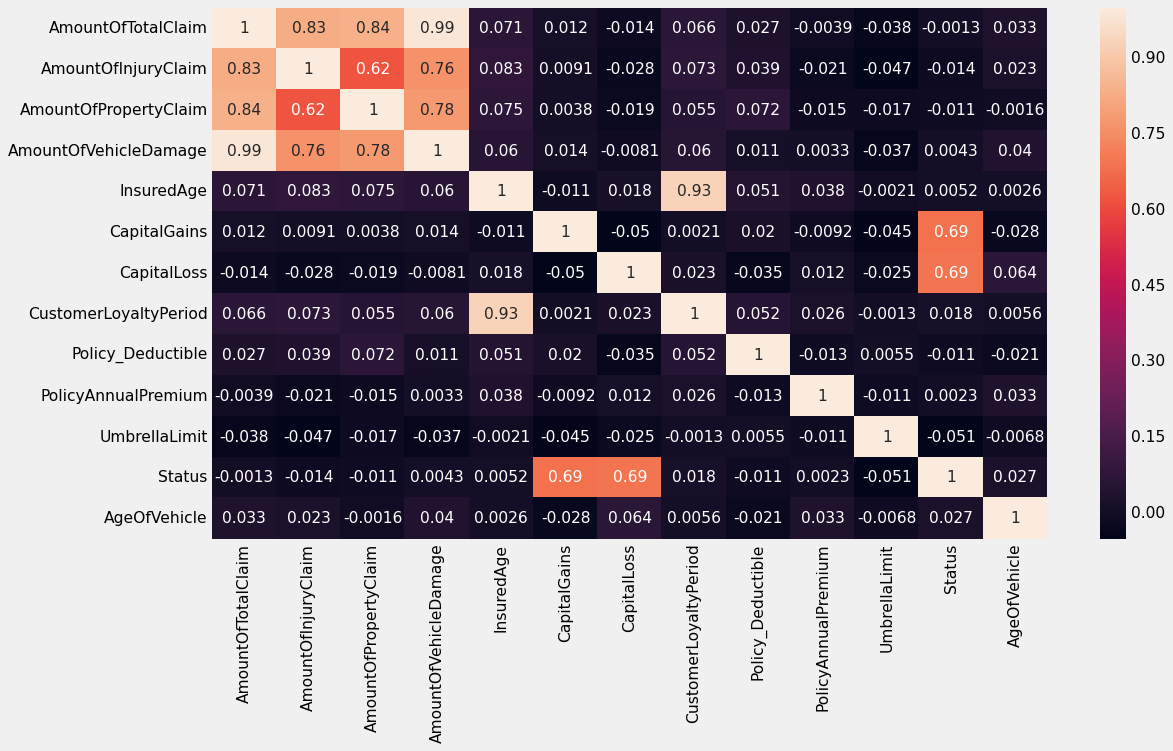

In [185]:
cor = data1.corr()
ax = sns.heatmap(cor, annot=True)

In [186]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [187]:
corr_features = correlation(data1, 0.75)
len(set(corr_features))

4

In [188]:
corr_features

{'AmountOfInjuryClaim',
 'AmountOfPropertyClaim',
 'AmountOfVehicleDamage',
 'CustomerLoyaltyPeriod'}

In [189]:
data1.drop(corr_features,axis=1, inplace=True)

In [190]:
num_attr =['AmountOfTotalClaim',
           'InsuredAge', 'CapitalGains', 'CapitalLoss',
           'Policy_Deductible',	'PolicyAnnualPremium', 'UmbrellaLimit',
            'AgeOfVehicle']
print(len(num_attr))
cat_attr = ['TypeOfIncident', 'TypeOfCollission', 'SeverityOfIncident',
       'AuthoritiesContacted', 'NumberOfVehicles', 'PropertyDamage',
       'BodilyInjuries', 'Witnesses', 'PoliceReport', 'InsuredGender',
       'InsuredHobbies', 'Policy_CombinedSingleLimit','IncidentPeriod', 'InsuredEducationLevel', 'IncidentState', 'InsuredOccupation',
        'VehicleMake']
len(cat_attr)

8


17

In [191]:
enc_cols = ['VehicleMake', 'InsuredOccupation', 'InsuredEducationLevel', 'IncidentState', 'InsuredHobbies']
data1[enc_cols] = data1[enc_cols].astype('object')

In [192]:
data1.dtypes

ReportedFraud                 category
TypeOfIncident                category
TypeOfCollission              category
SeverityOfIncident            category
AuthoritiesContacted          category
IncidentState                   object
NumberOfVehicles              category
PropertyDamage                category
BodilyInjuries                category
Witnesses                     category
PoliceReport                  category
AmountOfTotalClaim               int64
InsuredAge                       int64
InsuredGender                 category
InsuredEducationLevel           object
InsuredOccupation               object
InsuredHobbies                  object
CapitalGains                     int64
CapitalLoss                      int64
InsurancePolicyState          category
Policy_CombinedSingleLimit    category
Policy_Deductible                int64
PolicyAnnualPremium            float64
UmbrellaLimit                    int64
VehicleMake                     object
IncidentPeriod           

In [193]:
data1['ReportedFraud'] = data1['ReportedFraud'].astype(int)

**TargetEncoding**

In [194]:
data1[['VehicleMake','ReportedFraud']].groupby(['VehicleMake'], 
                                              as_index=False).mean().sort_values(by = 'ReportedFraud', ascending = False)

,VehicleMake,ReportedFraud
1,Audi,0.334529
5,Ford,0.333179
8,Mercedes,0.332128
2,BMW,0.328509
13,Volkswagen,0.306122
4,Dodge,0.290764
3,Chevrolet,0.275069
11,Suburu,0.260268
12,Toyota,0.250379
6,Honda,0.247153


In [195]:
data1['VehicleMake'] = data1['VehicleMake'].replace(('Saab', 'Suburu', 'Nissan', 'Dodge', 'Chevrolet', 'Ford',
                              'Accura', 'BMW', 'Toyota', 'Volkswagen', 'Audi', 'Jeep', 'Mercedes', 'Honda'),
                              (0.238923, 0.260268, 0.213478, 0.290764, 0.275069, 0.333179, 0.192473, 0.328509,
                               0.250379, 0.306122, 0.334529, 0.190134, 0.332128, 0.247153))

In [196]:
data1[['InsuredOccupation','ReportedFraud']].groupby(['InsuredOccupation'], 
                                              as_index=False).mean().sort_values(by = 'ReportedFraud', ascending = False)

,InsuredOccupation,ReportedFraud
3,exec-managerial,0.399441
4,farming-fishing,0.335172
13,transport-moving,0.302068
11,sales,0.296765
12,tech-support,0.291446
2,craft-repair,0.291080
10,protective-serv,0.279883
1,armed-forces,0.269685
9,prof-specialty,0.251058
5,handlers-cleaners,0.235414


In [197]:
data1['InsuredOccupation'] = data1['InsuredOccupation'].replace(('exec-managerial', 'farming-fishing', 'transport-moving', 'sales',
                                                                 'tech-support', 'craft-repair', 'protective-serv', 'armed-forces',
                                                                 'prof-specialty', 'handlers-cleaners', 'machine-op-inspct', 'priv-house-serv',
                                                                'other-service', 'adm-clerical'),
                                                                (0.399441,	0.33517, 0.302068, 0.296765,	0.291446, 0.291080, 0.279883, 0.269685,
                                                                 0.251058, 0.235414, 0.224803, 0.218290, 0.204071, 0.189709))

In [198]:
data1[['IncidentState','ReportedFraud']].groupby(['IncidentState'], 
                                              as_index=False).mean().sort_values(by = 'ReportedFraud', ascending = False)

,IncidentState,ReportedFraud
0,State3,0.415973
1,State4,0.335094
4,State7,0.332450
3,State6,0.316049
5,State8,0.242377
2,State5,0.238651
6,State9,0.199318


In [199]:
data1['IncidentState'] = data1['IncidentState'].replace(('State3', 'State4', 'State7', 'State6', 'State8', 'State5', 'State9'),
                                                      (0.415973, 0.335094, 0.332450, 0.316049,0.242377, 0.238651,0.199318  ))

In [200]:
data1[['InsuredHobbies','ReportedFraud']].groupby(['InsuredHobbies'], 
                                              as_index=False).mean().sort_values(by = 'ReportedFraud', ascending = False)

,InsuredHobbies,ReportedFraud
5,chess,0.801653
6,cross-fit,0.752602
19,yachting,0.331090
14,polo,0.315217
2,board-games,0.292264
0,base-jumping,0.272789
15,reading,0.269861
18,video-games,0.261972
16,skydiving,0.250179
13,paintball,0.228673


In [201]:
data1['InsuredHobbies'] = data1['InsuredHobbies'].replace(('chess', 'cross-fit', 'yachting', 'polo', 'board-games', 'base-jumping', 'reading', 'video-games',
'skydiving', 'paintball', 'movies', 'exercise', 'sleeping', 'hiking', 'bungie-jumping', 'basketball', 'golf', 'camping', 'kayaking', 'dancing'),
(	0.801653, 0.752602, 0.331090, 0.315217, 0.292264, 0.272789, 0.269861, 0.261972, 0.250179, 0.228673, 0.223022,  0.211454, 0.210656, 0.198247, 0.195888,
 0.185444, 0.153061, 0.149911, 0.139665, 0.118950))

In [202]:
data1.head()

,ReportedFraud,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,...,CapitalLoss,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,VehicleMake,IncidentPeriod,Status,AgeOfVehicle
0,0,Multi-vehicle Collision,Rear Collision,Total Loss,Other,0.199318,3,?,1,1.0,...,-42700,State2,250/500,2000,1142.87,0,0.332128,evening,-42700,10
1,0,Single Vehicle Collision,Side Collision,Minor Damage,Ambulance,0.335094,1,?,1,1.0,...,0,State2,100/300,1000,1274.38,2857344,0.250379,afternoon,51300,5
2,0,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,0.238651,3,?,0,0.0,...,0,State1,500/1000,745,1269.93,0,0.306122,night,0,13
3,1,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,0.332450,3,YES,2,0.0,...,-56100,State2,100/300,986,1218.60,0,0.250379,fore-noon,-8700,4
4,1,Multi-vehicle Collision,Side Collision,Major Damage,Other,0.335094,3,NO,1,2.0,...,0,State3,250/500,576,1431.02,4235779,0.333179,past_midnight,0,5


In [203]:
#Splitting into Test and Train
from sklearn.model_selection import train_test_split
y = data1['ReportedFraud']
X = data1.drop('ReportedFraud', axis=1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

In [204]:
#Imputing with median
imputer = SimpleImputer(strategy='median')
imputer.fit(X1_train[num_attr])

X1_train[num_attr] = imputer.transform(X1_train[num_attr])
X1_test[num_attr] = imputer.transform(X1_test[num_attr])

In [205]:
#Imputing with mode
imputer1 = SimpleImputer(strategy='most_frequent')
imputer1.fit(X1_train[cat_attr])

X1_train[cat_attr] = imputer1.transform(X1_train[cat_attr])
X1_test[cat_attr] = imputer1.transform(X1_test[cat_attr])

In [206]:
X1_train.shape

(21627, 27)

In [207]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X1_train[num_attr])

X1_train_num = pd.DataFrame(scaler.transform(X1_train[num_attr]), columns=num_attr)
X1_test_num= pd.DataFrame(scaler.transform(X1_test[num_attr]), columns=num_attr)

In [208]:
ohe = OneHotEncoder()

ohe.fit(X1_train[cat_attr])
columns_ohe = list(ohe.get_feature_names(cat_attr))

In [209]:
X1_train_cat = ohe.transform(X1_train[cat_attr])
X1_test_cat  = ohe.transform(X1_test[cat_attr])

In [210]:
X1_train_cat = pd.DataFrame(X1_train_cat.todense(), columns=columns_ohe)
X1_test_cat  = pd.DataFrame(X1_test_cat.todense(), columns=columns_ohe)

In [211]:
X1_train = pd.concat([X1_train_num, X1_train_cat], axis=1)
X1_test = pd.concat([X1_test_num, X1_test_cat], axis=1)

In [212]:
print(X1_train.shape, X1_test.shape)

(21627, 122) (7209, 122)


In [218]:
#Function to print algorithm used and F1score on test and train
scores1 = pd.DataFrame(columns=['Model', 'Train_F1_Score', 'Test_F1_Score', 'Train_accuracy', 'Test_accuracy'])

def metrics(train_actual, train_predicted, test_actual, test_predicted, model_description, dataframe):
    train_f1score   = f1_score(train_actual, train_predicted)
    test_f1score    = f1_score(test_actual, test_predicted)
    train_accuracy   = accuracy_score(train_actual, train_predicted)
    test_accuracy    = accuracy_score(test_actual, test_predicted)

    dataframe       = dataframe.append(pd.Series([model_description, train_f1score,
                                                  test_f1score, train_accuracy, test_accuracy],
                                                 index=scores1.columns ), 
                                       ignore_index=True)

    return(dataframe)

In [219]:
#Creating a list for classifiers
from sklearn.svm import SVC
classifiers_final={'lgb': lgb.LGBMClassifier(),
'Xgb': XGBClassifier(),
'Gbm':GradientBoostingClassifier(),
'svc':SVC(),}

In [220]:
%%time
from sklearn.metrics import confusion_matrix
for key, classifier in classifiers_final.items():
    classifier.fit(X1_train, y1_train)
    y1_pred_train= classifier.predict(X1_train)
    y1_pred_test=classifier.predict(X1_test)
    
    print('Train')
    print(recall_score(y1_train, y1_pred_train))
    print(accuracy_score(y1_train, y1_pred_train))
    print(precision_score(y1_train, y1_pred_train))
    print(f1_score(y1_train, y1_pred_train))
    print("--------------------------------------------------------------------------------")
    print("Test")
    print(recall_score(y1_test, y1_pred_test))
    print(accuracy_score(y1_test, y1_pred_test))
    print(precision_score(y1_test, y1_pred_test))
    print(f1_score(y1_test, y1_pred_test))
    print("---------------------------------------------------------------------------------")
   
    scores1 = metrics(y1_train, y1_pred_train, y1_test, y1_pred_test, classifier.__class__.__name__, scores1)

Train
0.7831820517211852
0.9219494150829981
0.9155155155155155
0.8441942034336348
--------------------------------------------------------------------------------
Test
0.7533401849948612
0.9053960327368568
0.8788968824940048
0.8112894299944658
---------------------------------------------------------------------------------
Train
0.70525774961466
0.8685901881906876
0.786027867913724
0.743455497382199
--------------------------------------------------------------------------------
Test
0.7019527235354573
0.861284505479262
0.7648376259798432
0.7320471596998928
---------------------------------------------------------------------------------
Train
0.7066278472341154
0.8675729412308688
0.7818836460109911
0.7423533645196114
--------------------------------------------------------------------------------
Test
0.7009249743062693
0.8603134970176168
0.7624371157070989
0.7303882195448461
---------------------------------------------------------------------------------
Train
0.7932865216646686
0.

In [221]:
scores1

,Model,Train_F1_Score,Test_F1_Score,Train_accuracy,Test_accuracy
0,LGBMClassifier,0.844194,0.811289,0.921949,0.905396
1,XGBClassifier,0.743455,0.732047,0.868590,0.861285
2,GradientBoostingClassifier,0.742353,0.730388,0.867573,0.860313
3,SVC,0.852646,0.831154,0.925972,0.915800
